# Breast Cancer Detection By Using Explainable Artificial Intelligence Methods

In [192]:
import opendatasets as od
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import tensorflow as tf
import keras.utils as image
import glob
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import random
import shutil
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications import ResNet50, VGG16
from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import keras

import shap
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

## Load Dataset

In [2]:
dataset_url = "https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  iremmhatipoglu


Your Kaggle Key:

  ········


100%|██████████| 3.10G/3.10G [02:05<00:00, 26.4MB/s]


In [3]:
#Dataset directory
dataset_dir = "./breast-histopathology-images"
print(os.listdir(dataset_dir))

['9036', '10268', '10257', '8913', '13613', '8914', '15510', '10259', '16165', '10292', '12951', '10261', '10295', '9259', '12750', '13020', '16552', '12905', '9266', '16555', '13018', '9261', '9257', '12934', '12933', '9250', '10260', '10258', '10293', '9037', '10269', '16531', '10256', '15516', '12932', '12935', '9256', '16554', '9260', '13019', '16553', '13021', '8984', '9258', '12751', '9267', '12876', '12882', '15634', '12871', '14188', '15633', '9324', '12878', '9323', '9383', '8867', '9346', '9174', '12822', '9173', '9322', '9325', '12879', '14189', '12870', '12884', '12241', '15632', '12883', '12877', '9126', '13106', '12823', '13591', '9175', '12824', '9347', '9181', '9382', '10307', '13916', '10300', '14306', '15471', '16896', '14156', '9135', '12890', '12897', '10308', '10301', '10306', '12896', '14157', '12891', '12898', '14192', '13458', '9083', '9077', '13460', '8955', '12910', '9041', '14210', 'IDC_regular_ps50_idx5', '14082', '10274', '9227', '10273', '13402', '14078', 

In [4]:
#Number of the files in the dataset directory
files = os.listdir(dataset_dir)
print(len(files))

280


In [5]:
#Number of the patients
base_path = "./breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = os.listdir(base_path)
len(folder)

279

The patient ID is a component of the file name format, as stated in the dataset description. In light of this situation, we discovered that this dataset contains the data of 279 patients.

In [6]:
#Total number of the images in the dataset
total_img = 0
for patient_id in os.listdir(dataset_dir):
    patient_path = os.path.join(dataset_dir, patient_id)
    for c in [0, 1]:
        class_path = os.path.join(patient_path, str(c))
        if os.path.exists(class_path):
            total_img += len(os.listdir(class_path))
print(f"There are {total_img} images in the dataset.")

There are 277524 images in the dataset.


## Data Preparation

For easier access to the dataset, we create a data frame that contains the components such as patient_id, path and target.

In [7]:
data = []

for patient_id in os.listdir(dataset_dir):
    patient_path = os.path.join(dataset_dir, patient_id)
    for label in [0, 1]:
        class_path = os.path.join(patient_path, str(label))
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                # Extract x and y coordinates from the filename
                coords = img_file.split('_')[2:4]
                x_coord, y_coord = int(coords[0][1:]), int(coords[1][1:])
                # Append data to the list
                data.append({
                    'patient_id': patient_id,
                    'path': img_path,
                    'x_coord': x_coord,
                    'y_coord': y_coord,
                    'label': label,
                })

df = pd.DataFrame(data)
df

,patient_id,path,x_coord,y_coord,label
0,9036,./breast-histopathology-images/9036/0/9036_idx...,1051,2401,0
1,9036,./breast-histopathology-images/9036/0/9036_idx...,2951,951,0
2,9036,./breast-histopathology-images/9036/0/9036_idx...,3001,1451,0
3,9036,./breast-histopathology-images/9036/0/9036_idx...,3051,801,0
4,9036,./breast-histopathology-images/9036/0/9036_idx...,951,1901,0
...,...,...,...,...,...
277519,8957,./breast-histopathology-images/8957/1/8957_idx...,1951,701,1
277520,8957,./breast-histopathology-images/8957/1/8957_idx...,2051,551,1
277521,8957,./breast-histopathology-images/8957/1/8957_idx...,1951,651,1
277522,8957,./breast-histopathology-images/8957/1/8957_idx...,1451,551,1


In [8]:
df.shape

(277524, 5)

In [9]:
cancer_df = df[df['label'] == 1].copy()
cancer_df

,patient_id,path,x_coord,y_coord,label
1276,9036,./breast-histopathology-images/9036/1/9036_idx...,1851,1351,1
1277,9036,./breast-histopathology-images/9036/1/9036_idx...,1851,1451,1
1278,9036,./breast-histopathology-images/9036/1/9036_idx...,1751,1601,1
1279,9036,./breast-histopathology-images/9036/1/9036_idx...,1801,1501,1
1280,9036,./breast-histopathology-images/9036/1/9036_idx...,1801,1201,1
...,...,...,...,...,...
277519,8957,./breast-histopathology-images/8957/1/8957_idx...,1951,701,1
277520,8957,./breast-histopathology-images/8957/1/8957_idx...,2051,551,1
277521,8957,./breast-histopathology-images/8957/1/8957_idx...,1951,651,1
277522,8957,./breast-histopathology-images/8957/1/8957_idx...,1451,551,1


In [10]:
healthy_df = df[df['label'] == 0].copy()
healthy_df

,patient_id,path,x_coord,y_coord,label
0,9036,./breast-histopathology-images/9036/0/9036_idx...,1051,2401,0
1,9036,./breast-histopathology-images/9036/0/9036_idx...,2951,951,0
2,9036,./breast-histopathology-images/9036/0/9036_idx...,3001,1451,0
3,9036,./breast-histopathology-images/9036/0/9036_idx...,3051,801,0
4,9036,./breast-histopathology-images/9036/0/9036_idx...,951,1901,0
...,...,...,...,...,...
277436,8957,./breast-histopathology-images/8957/0/8957_idx...,251,51,0
277437,8957,./breast-histopathology-images/8957/0/8957_idx...,201,201,0
277438,8957,./breast-histopathology-images/8957/0/8957_idx...,151,251,0
277439,8957,./breast-histopathology-images/8957/0/8957_idx...,1951,751,0


## Data Visualisation

After creating the data frame for easy usage, it is time to take a look at the images of the dataset. 

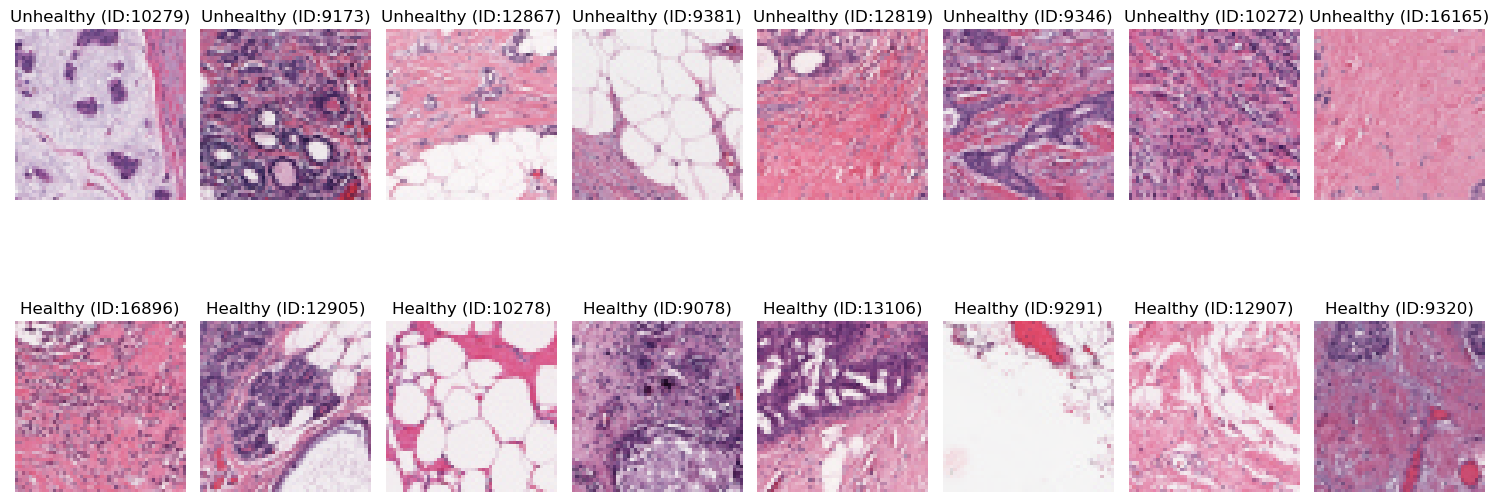

In [11]:
unhealthy_images = df[df['label'] == 1]
healthy_images = df[df['label'] == 0]

# Visualize random samples of images with the same x and y coordinates
num_images_to_display = 8
random_x_y_coordinates = unhealthy_images[['x_coord', 'y_coord']].sample(num_images_to_display)

fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 7))

for i, (index, row) in enumerate(random_x_y_coordinates.iterrows()):
    x_coord = row['x_coord']
    y_coord = row['y_coord']
    
    # Select unhealthy image with the same x and y coordinates
    unhealthy_img_row = unhealthy_images[(unhealthy_images['x_coord'] == x_coord) & (unhealthy_images['y_coord'] == y_coord)].sample(1)
    unhealthy_img_path = unhealthy_img_row['path'].iloc[0]
    unhealthy_img = mpimg.imread(unhealthy_img_path)
    
    # Select healthy image with the same x and y coordinates
    healthy_img_row = healthy_images[(healthy_images['x_coord'] == x_coord) & (healthy_images['y_coord'] == y_coord)].sample(1)
    healthy_img_path = healthy_img_row['path'].iloc[0]
    healthy_img = mpimg.imread(healthy_img_path)
    
    axes[0, i].imshow(unhealthy_img)
    axes[0, i].set_title(f"Unhealthy (ID:{unhealthy_img_row['patient_id'].iloc[0]})")
    axes[0, i].axis('off')
    axes[1, i].imshow(healthy_img)
    axes[1, i].set_title(f"Healthy (ID:{healthy_img_row['patient_id'].iloc[0]})")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

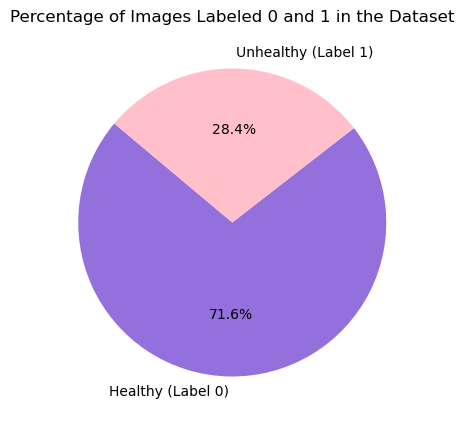

In [12]:
label_counts = df['label'].value_counts()
colors = ['#9370DB', '#FFC0CB']
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=['Healthy (Label 0)', 'Unhealthy (Label 1)'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Images Labeled 0 and 1 in the Dataset')
plt.show()

<Figure size 1200x600 with 0 Axes>

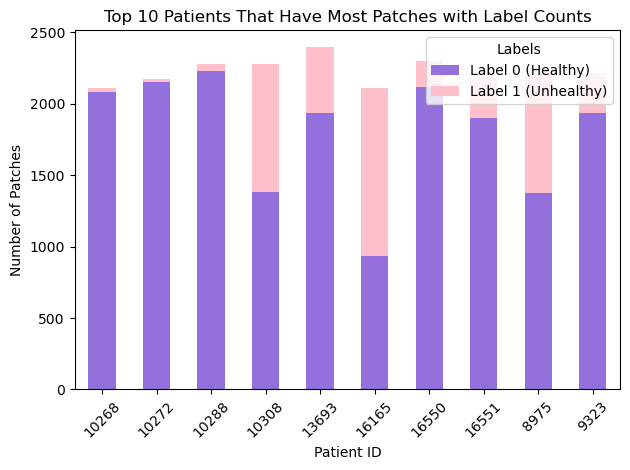

In [13]:
patches_per_patient = df['patient_id'].value_counts()
top_patients = patches_per_patient.head(10)
top_patients_df = df[df['patient_id'].isin(top_patients.index)]

# Group the data by patient ID and label, and count the occurrences
grouped_data = top_patients_df.groupby(['patient_id', 'label']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
grouped_data.plot(kind='bar', stacked=True, color=['#9370DB', '#FFC0CB'])
plt.title('Top 10 Patients That Have Most Patches with Label Counts')
plt.xlabel('Patient ID')
plt.ylabel('Number of Patches')
plt.xticks(rotation=45)
plt.legend(title='Labels', labels=['Label 0 (Healthy)', 'Label 1 (Unhealthy)'], loc='upper right')
plt.tight_layout()
plt.show()

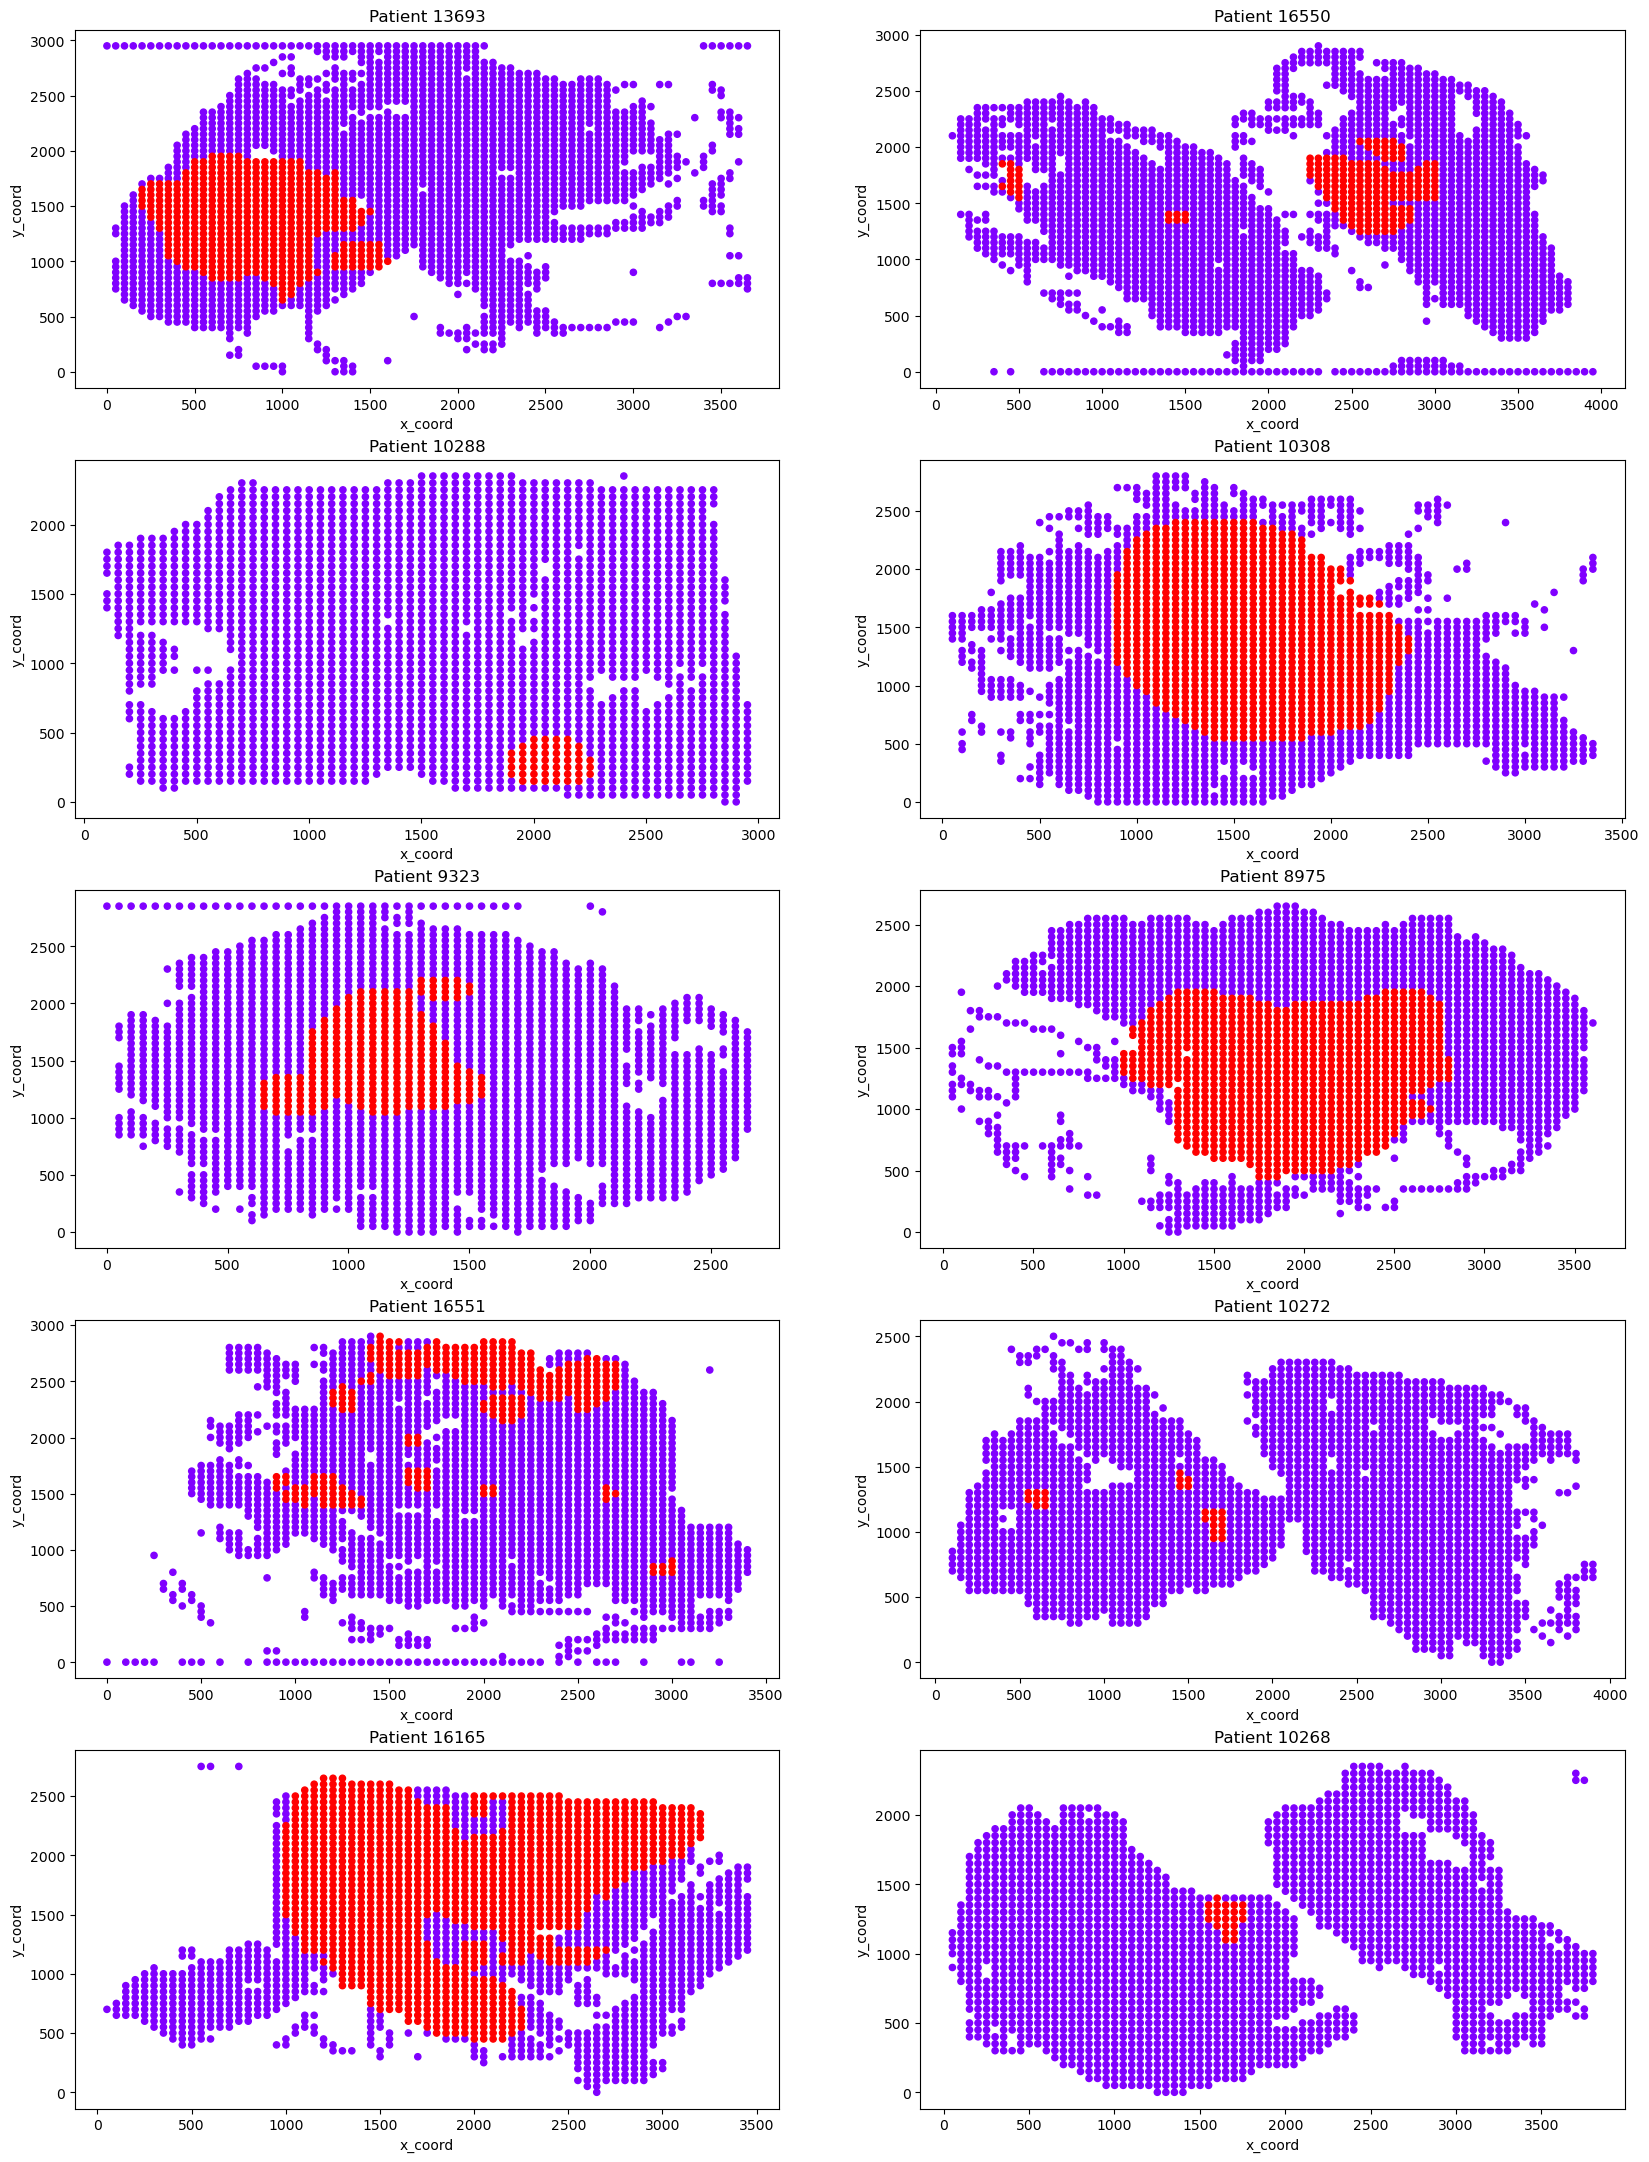

In [14]:
#Binary Label Visualisation

patches_per_patient = df['patient_id'].value_counts()
top_patients = patches_per_patient.head(10).index.tolist()

fig, ax = plt.subplots(5, 2, figsize=(20, 27))

for i, patient_id in enumerate(top_patients):
    n = i // 2
    m = i % 2
    
    binary_df = df[df['patient_id'] == patient_id]
    ax[n, m].scatter(binary_df['x_coord'], binary_df['y_coord'], c=binary_df['label'], cmap="rainbow", s=20)
    ax[n, m].set_title("Patient " + patient_id)
    ax[n, m].set_xlabel("x_coord")
    ax[n, m].set_ylabel("y_coord")

plt.show()

In [15]:
#Function for visualising the tissue image and labelled parts of it.

def visualise_tissue(patient_id, pred_df=None):
    
    tissue_df = df[df['patient_id'] == patient_id]
    max_point = [tissue_df.y_coord.max()-1, tissue_df.x_coord.max()-1]
    
    grid = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    
    
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape=(max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    
    #Processing Patches
    for n in range(len(tissue_df)):
        try:
            image = cv2.imread(tissue_df.path.values[n])
            
            target = tissue_df.label.values[n]
            
            x_coord = np.int(tissue_df.x_coord.values[n])
            y_coord = np.int(tissue_df.y_coord.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                proba = patient_df[
                    (patient_df.x_coord==x_coord) & (patient_df.y_coord==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(tissue_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

/var/folders/m2/v1zb3l9x15s2k4m5gvyrf7vw0000gn/T/ipykernel_8450/3645959954.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_proba = np.zeros(shape=(max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
/var/folders/m2/v1zb3l9x15s2k4m5gvyrf7vw0000gn/T/ipykernel_8450/3645959954.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

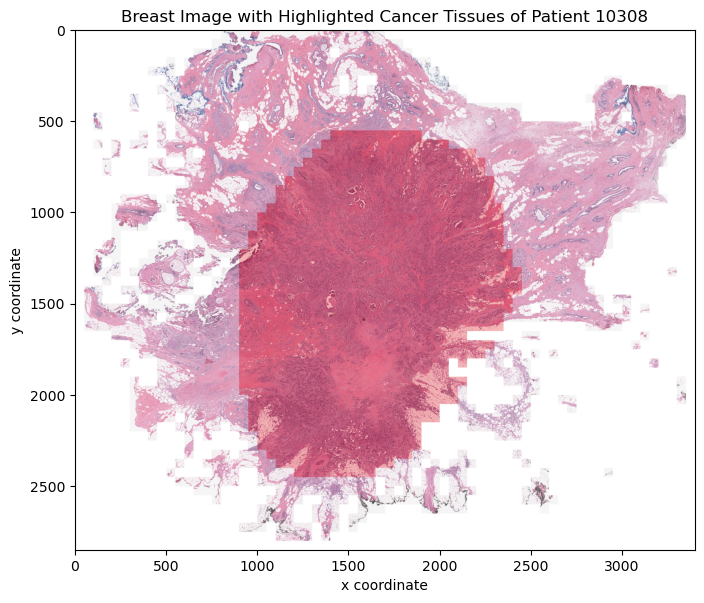

In [16]:
patient_id = "10308"
grid, mask, broken_patches,_ = visualise_tissue(patient_id)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mask, alpha=0.8)
ax.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB), alpha=0.7)
ax.grid(False)
ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")
ax.set_title("Breast Image with Highlighted Cancer Tissues of Patient " + patient_id)
plt.show()

In [17]:
broken_patches

['./breast-histopathology-images/10308/0/10308_idx5_x3351_y501_class0.png',
 './breast-histopathology-images/10308/0/10308_idx5_x3351_y451_class0.png',
 './breast-histopathology-images/10308/0/10308_idx5_x3351_y401_class0.png',
 './breast-histopathology-images/10308/0/10308_idx5_x3351_y2001_class0.png',
 './breast-histopathology-images/10308/0/10308_idx5_x3351_y2101_class0.png',
 './breast-histopathology-images/10308/0/10308_idx5_x3351_y2051_class0.png',
 './breast-histopathology-images/10308/0/10308_idx5_x1101_y2801_class0.png',
 './breast-histopathology-images/10308/0/10308_idx5_x1151_y2801_class0.png',
 './breast-histopathology-images/10308/0/10308_idx5_x1251_y2801_class0.png',
 './breast-histopathology-images/10308/0/10308_idx5_x1201_y2801_class0.png']

##### Data Preprocessing

In [18]:
def resize_images(dataset_dir):
    for patient_id in os.listdir(dataset_dir):
        patient_path = os.path.join(dataset_dir, patient_id)
        for label in [0, 1]:
            class_path = os.path.join(patient_path, str(label))
            if os.path.exists(class_path):
                for img_file in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_file)
                    img = cv2.imread(img_path)
                    resized_img = cv2.resize(img, (50, 50))
                    cv2.imwrite(img_path, resized_img)

resize_images(dataset_dir)

In [19]:
def restructure_dataset(dataset_dir):
    cancer_dir = os.path.join(dataset_dir, "cancer")
    healthy_dir = os.path.join(dataset_dir, "healthy")
    
    os.makedirs(cancer_dir, exist_ok=True)
    os.makedirs(healthy_dir, exist_ok=True)
    
    for patient_id in os.listdir(dataset_dir):
        patient_path = os.path.join(dataset_dir, patient_id)
        if os.path.isdir(patient_path):
            for label in ["1", "0"]:
                label_path = os.path.join(patient_path, label)
                if os.path.isdir(label_path):
                    destination_dir = cancer_dir if label == "1" else healthy_dir
                    for img_file in os.listdir(label_path):
                        src = os.path.join(label_path, img_file)
                        dest = os.path.join(destination_dir, img_file)
                        shutil.move(src, dest)
    
    print("Dataset restructuring completed.")

In [20]:
restructure_dataset(dataset_dir)

Dataset restructuring completed.


In [21]:
def delete_extra_folders(dataset_dir):
    all_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    
    folders_to_keep = ["cancer", "healthy"]
    
    for folder in all_dirs:
        if folder not in folders_to_keep:
            folder_path = os.path.join(dataset_dir, folder)
            if os.path.isdir(folder_path):
                shutil.rmtree(folder_path)

In [22]:
delete_extra_folders(dataset_dir)

In [23]:
def visualize_dataset(dataset_dir):
    all_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    
    image_counts = {}
    for folder in all_dirs:
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            image_counts[folder] = len(os.listdir(folder_path))
    
    # Plot the results
    plt.figure(figsize=(6, 6))
    plt.bar(image_counts.keys(), image_counts.values(), color=['#9370DB', '#FFC0CB'])
    plt.xlabel('Folders')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Folder')
    plt.xticks(rotation=45)
    plt.show()

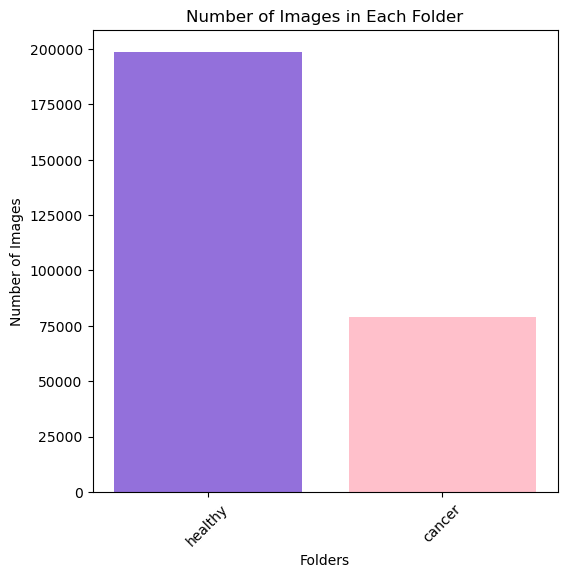

In [24]:
visualize_dataset(dataset_dir)

In [25]:
images_per_label = df['label'].value_counts()

print("Number of images per label:")
print(images_per_label)

Number of images per label:
label
0    198738
1     78786
Name: count, dtype: int64


In [26]:
def delete_random_images(folder_path, num_images_to_delete):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    images_to_delete = random.sample(image_files, num_images_to_delete)
    
    for image in images_to_delete:
        os.remove(os.path.join(folder_path, image))
    
    print(f"{num_images_to_delete} random images deleted from the folder.")

healthy_folder_path = os.path.join(dataset_dir, "healthy")

In [27]:
num_images_to_delete = 119952
delete_random_images(healthy_folder_path, num_images_to_delete)

119952 random images deleted from the folder.


In [29]:
def count_images_per_folder(dataset_dir):
    folders = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    image_counts = {}
    for folder in folders:
        folder_path = os.path.join(dataset_dir, folder)
        num_images = sum([len(files) for _, _, files in os.walk(folder_path)])
        image_counts[folder] = num_images
    return image_counts

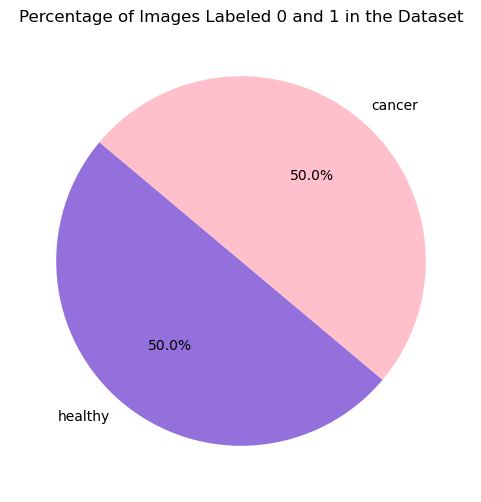

In [33]:
image_counts = count_images_per_folder(dataset_dir)
colors = ['#9370DB', '#FFC0CB']
plt.figure(figsize=(6, 6))
plt.pie(image_counts.values(), labels=image_counts.keys(), autopct='%1.1f%%', startangle=140,  colors=colors)
plt.title('Percentage of Images Labeled 0 and 1 in the Dataset')
plt.show()

In [36]:
def get_images(directory):
    Images = []
    Labels = [] 
    
    for labels in os.listdir(directory):
        
        for image_file in os.listdir(directory+labels):
            image = cv2.imread(directory+labels+r'/'+image_file)
            image = cv2.resize(image,(128,128))
            Images.append(image)
            Labels.append(labels)
    
    return shuffle(Images,Labels,random_state=817328462) 

In [37]:
#Train data
Images, Labels = get_images("./breast-histopathology-images/")

Images = np.array(Images) 
Labels = np.array(Labels)

In [38]:
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(Labels)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(Images, encoded_labels, test_size=0.2, random_state=42)

In [40]:
from collections import Counter
Counter(encoded_labels)

Counter({0: 78786, 1: 78786})

## Modelling

In [42]:
def deep_learning(base_model, input_shape=(128, 128, 3), num_classes=4):
    model = Sequential()
    model.add(base_model(include_top=False, weights='imagenet', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    return model

In [44]:
#VGG16
vgg_model = deep_learning(VGG16)
vgg_model.summary()

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_vgg = vgg_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_5 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_6 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_7 (Dense)             (None, 256)               262400    
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 4)                

Epoch 1/5
3940/3940 [==============================] - 4676s 1s/step - loss: 0.4071 - accuracy: 0.8259 - val_loss: 0.3738 - val_accuracy: 0.8382
Epoch 2/5
3940/3940 [==============================] - 7046s 2s/step - loss: 0.3322 - accuracy: 0.8588 - val_loss: 0.3665 - val_accuracy: 0.8407
Epoch 3/5
3940/3940 [==============================] - 7064s 2s/step - loss: 0.2640 - accuracy: 0.8909 - val_loss: 0.3921 - val_accuracy: 0.8411
Epoch 4/5
3940/3940 [==============================] - 7344s 2s/step - loss: 0.1758 - accuracy: 0.9311 - val_loss: 0.5276 - val_accuracy: 0.8380
Epoch 5/5
3940/3940 [==============================] - 4485s 1s/step - loss: 0.1102 - accuracy: 0.9575 - val_loss: 0.6588 - val_accuracy: 0.8372


In [45]:
#ResNet50
resnet_model = deep_learning(ResNet50)
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_resnet = resnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_10 (Dense)            (None, 4096)              134221824 
                                                                 
 dense_11 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_12 (Dense)            (None, 256)               262400    
                                                                 
 dense_13 (Dense)            (None, 64)                16448     
                                                                 
 dense_14 (Dense)            (None, 4)                

Epoch 1/5
3940/3940 [==============================] - 3047s 773ms/step - loss: 0.3737 - accuracy: 0.8401 - val_loss: 0.3456 - val_accuracy: 0.8496
Epoch 2/5
3940/3940 [==============================] - 3276s 832ms/step - loss: 0.3166 - accuracy: 0.8655 - val_loss: 0.3655 - val_accuracy: 0.8416
Epoch 3/5
3940/3940 [==============================] - 3217s 816ms/step - loss: 0.2703 - accuracy: 0.8880 - val_loss: 0.3472 - val_accuracy: 0.8559
Epoch 4/5
3940/3940 [==============================] - 3053s 775ms/step - loss: 0.2084 - accuracy: 0.9157 - val_loss: 0.4198 - val_accuracy: 0.8476
Epoch 5/5
3940/3940 [==============================] - 3371s 855ms/step - loss: 0.1457 - accuracy: 0.9435 - val_loss: 0.5874 - val_accuracy: 0.8464


## Model Evaluation

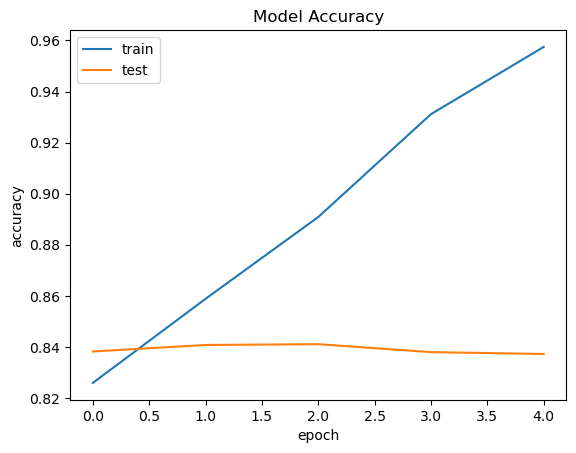

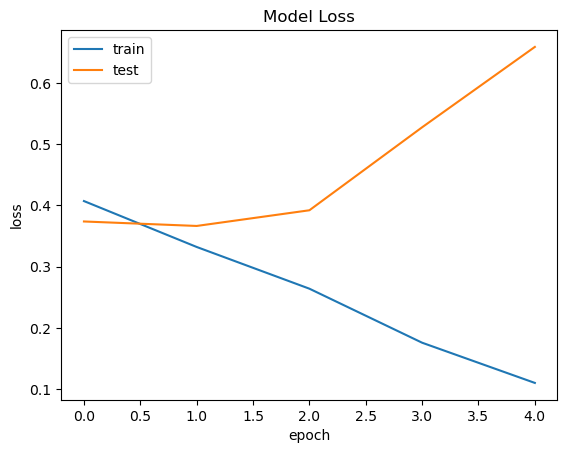

In [46]:
#VGG16
plt.plot(training_history_vgg.history['accuracy'])
plt.plot(training_history_vgg.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(training_history_vgg.history['loss'])
plt.plot(training_history_vgg.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

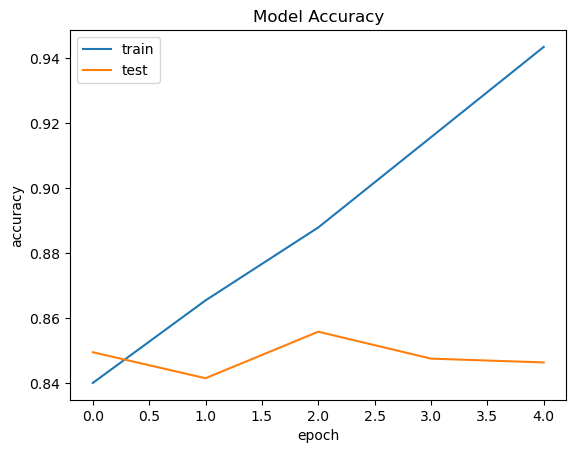

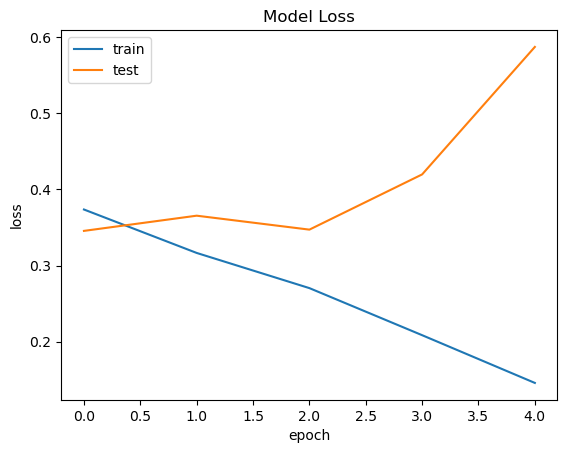

In [47]:
#ResNet50
plt.plot(training_history_resnet.history['accuracy'])
plt.plot(training_history_resnet.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(training_history_resnet.history['loss'])
plt.plot(training_history_resnet.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save

In [49]:
# Save the models
vgg_model.save("vgg_model.h5")
resnet_model.save("resnet_model.h5")

In [84]:
from keras.models import load_model

# Load the models
vgg_model = load_model("vgg_model.h5")
model = load_model("resnet_model.h5")

In [99]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Explainable AI

### Grad-CAM (Gradient-weighted Class Activation Mapping)

In [244]:
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array
    
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [245]:
image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
            image_files.append(os.path.join(root, file))

random_image_path = random.choice(image_files)

img_array = get_img_array(random_image_path, size=(224, 224))

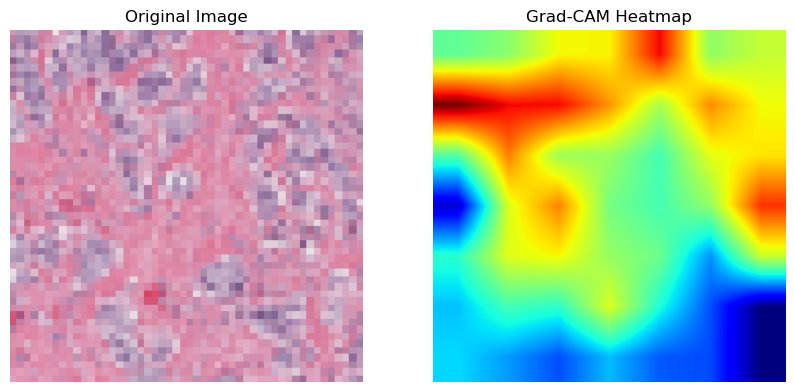

In [246]:
heatmap = make_gradcam_heatmap(img_array, resnet_model, "conv5_block3_out")
heatmap_expanded = np.expand_dims(heatmap, axis=(0, -1))
heatmap_resized = tf.image.resize(heatmap_expanded, (img_array.shape[1], img_array.shape[2]))

heatmap_resized = tf.squeeze(heatmap_resized)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array[0] / 255) 
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(heatmap_resized, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()

### SHAP

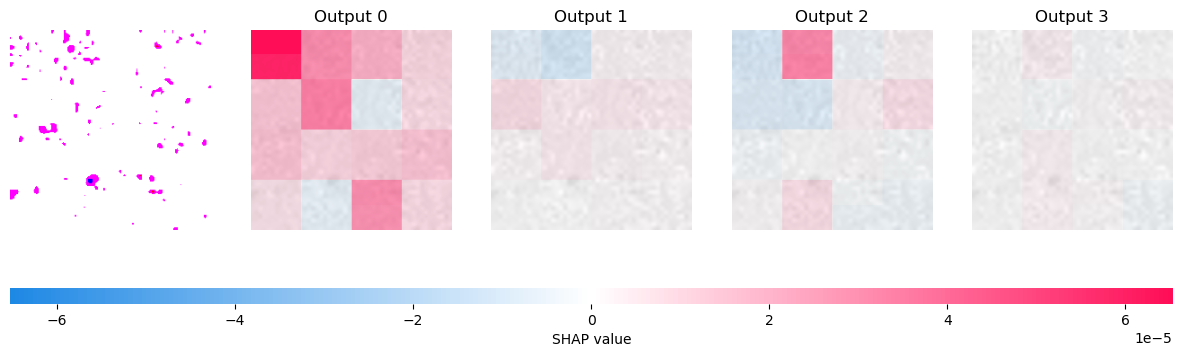

In [247]:
img = Image.open(random_image_path).resize((224, 224))
img_array = np.array(img)
preprocessed_img = preprocess_input(img_array)

preprocessed_img_reshaped = np.expand_dims(preprocessed_img, axis=0)

def f(x):
    preprocess_input(x)
    return model(x)

masker = shap.maskers.Image("inpaint_telea", preprocessed_img_reshaped.shape[1:])

explainer = shap.Explainer(f, masker)
shap_values = explainer(preprocessed_img_reshaped, max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values)

### LIME

100%|██████████| 1000/1000 [00:35<00:00, 28.38it/s]


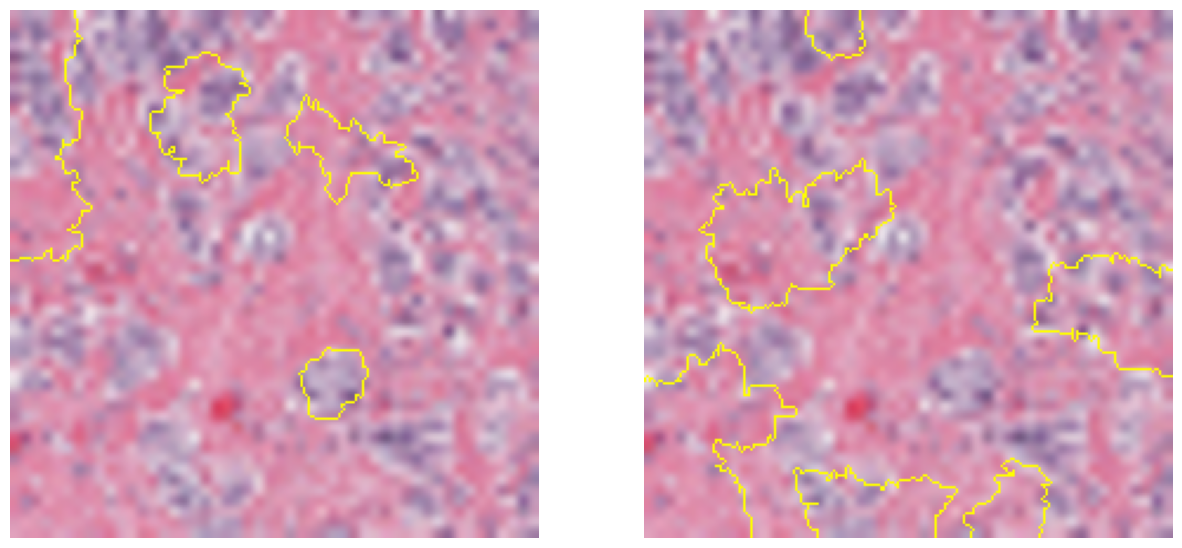

In [248]:
img = Image.open(random_image_path).resize((224, 224))
img_array = np.array(img) / 255.0 

explainer = lime_image.LimeImageExplainer()

def predict_function(images):
    preprocessed_images = preprocess_input(images)
    return model(preprocessed_images)
    

explanation = explainer.explain_instance(img_array, predict_function, top_labels=3, hide_color=0, num_samples=1000)

temp_pos, mask_pos = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, negative_only=False, num_features=5, hide_rest=False)
temp_neg, mask_neg = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, negative_only=True, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_pos, mask_pos))
ax2.imshow(mark_boundaries(temp_neg, mask_neg))
ax1.axis('off')
ax2.axis('off')
plt.show()